# Test GPU

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib 

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2814134530426068914]

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

# import libs

In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf

import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error

from ipywidgets import interact, interact_manual

# data read and analise

In [5]:
df = pd.read_csv('covid19_by_settlement_dynamics.csv')
df.head()

,zvit_date,registration_area,registration_region,registration_settlement,registration_settlement_lng,registration_settlement_lat,new_susp,new_confirm,active_confirm,new_death,new_recover
0,2020-01-01,Донецька,Мангушський район,Мелекіне,37.394099,46.957301,0,0,0,1,0
1,2020-01-07,Донецька,Краматорськ,Краматорськ,37.584350,48.738967,0,0,0,1,0
2,2020-01-12,Запорізька,Запоріжжя,Запоріжжя,35.139567,47.838800,0,0,0,1,0
3,2020-01-19,Закарпатська,Берегівський район,Берегуйфалу,22.807531,48.279628,0,0,0,1,0
4,2020-01-22,Донецька,Українськ,Українськ,37.362549,48.096803,0,0,0,1,0


In [6]:
df.isnull().values.any()

False

In [7]:
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

In [8]:
df.isnull().sum().sum()

0

In [9]:
def add_info(df, column):
    cnt = df[column].count()
    sm = df[column].sum()
    print(' Column[{}]: count elements: {}, sum of elements: {}'.format(column, cnt, sm))

# show information from frame and list of columns to show
def show_all_information(df, x_lable, y_lables, element_number=None, kind_of_line="line"):
    if element_number == None:
        element_number = len(df)
    df.plot(x=x_lable, y=y_lables, kind="line", linestyle='-', marker='o')
    plt.show()
    
    print("Add information:")
    print(('Days: \n Column[{}]: count elements: {}. \nOther: '.format(x_lable, df[x_lable].count())))
    
    for col in y_lables:
        add_info(df, col)

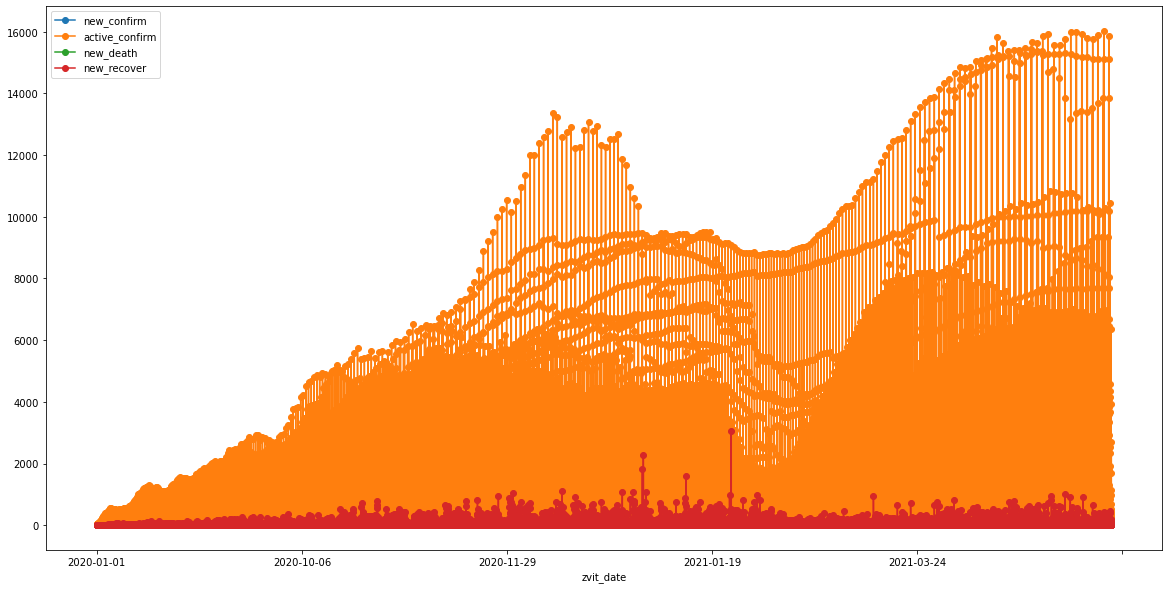

Add information:
Days: 
 Column[zvit_date]: count elements: 2473510. 
Other: 
 Column[new_confirm]: count elements: 2473510, sum of elements: 2069537
 Column[active_confirm]: count elements: 2473510, sum of elements: 49999144
 Column[new_death]: count elements: 2473510, sum of elements: 44087
 Column[new_recover]: count elements: 2473510, sum of elements: 1655525


In [10]:
show_all_information(df, "zvit_date", ["new_confirm", "active_confirm", "new_death", "new_recover"])

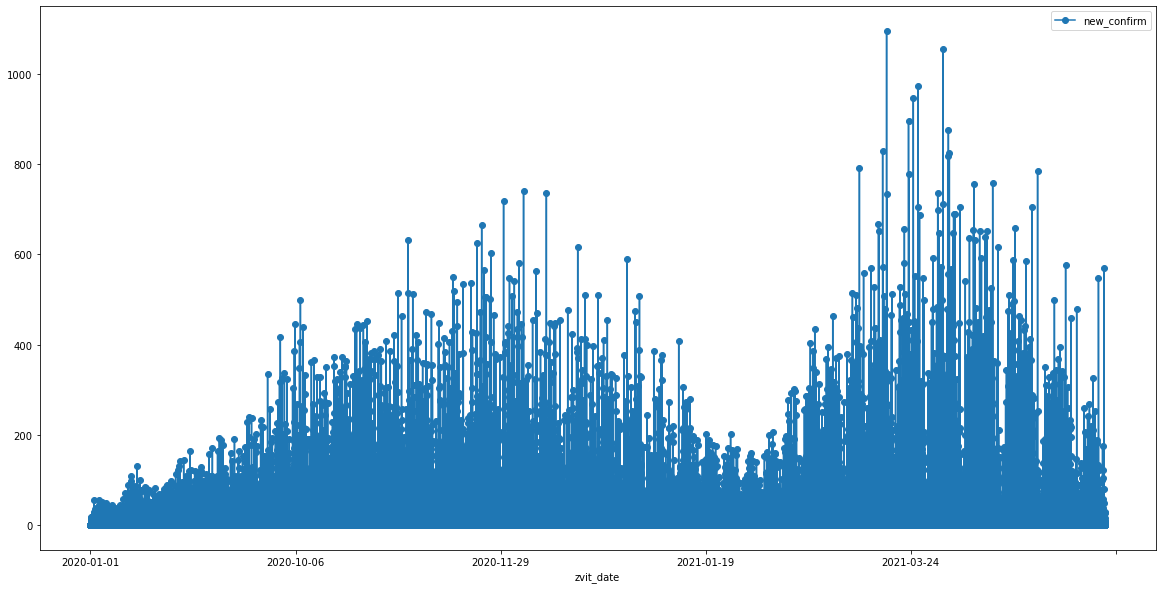

Add information:
Days: 
 Column[zvit_date]: count elements: 2473510. 
Other: 
 Column[new_confirm]: count elements: 2473510, sum of elements: 2069537


In [11]:
show_all_information(df, "zvit_date", ["new_confirm"])

In [12]:
def plot_timeline_statistic(column):
    y = column
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Default')
    ax.plot(y.resample('D').mean(),marker='o',linewidth=0.5, markersize=8, linestyle='-', label='Day')
    ax.plot(y.resample('W').mean(),marker='o',linewidth=0.5, markersize=8, linestyle='-', label='Week')
    ax.plot(y.resample('M').mean(),marker='o', linewidth=0.5, markersize=8, linestyle='-', label='Month')
    ax.set_ylabel('new_column')
    ax.legend();
    
def create_new_data_frame(df, headers_list):
    data = [df[x] for x in headers_list]
    new_df = pd.concat(data, axis=1)
    new_df.index = new_df.zvit_date
    new_df = new_df.drop(['zvit_date'], axis=1)
    return new_df

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

def plot_general_info(df, column, f_sum=None):
    general_info_slice = create_new_data_frame(df, default_features)
    general_info_slice.index = pd.to_datetime(df[time_column])
    if f_sum != None:
        general_info_slice = general_info_slice[:].resample(f_sum).sum()
        if f_sum == 'D':
            seasonal_decompose(general_info_slice[column])
    
    plot_timeline_statistic(general_info_slice[column])

In [13]:
# init info for later modeling and forecasting
default_features = ['zvit_date', "registration_area", 'new_susp', 'new_confirm', 'new_death', 'new_recover'] # show information with date, region and other features
time_column = 'zvit_date'
region = "registration_area"

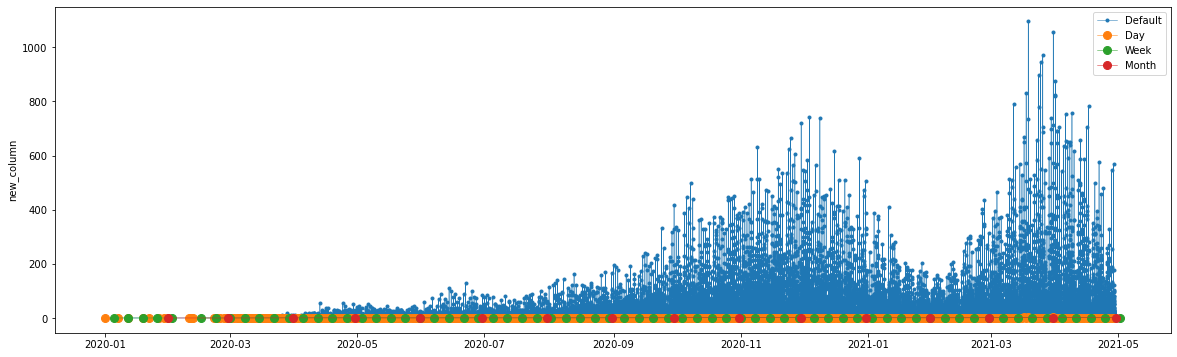

In [14]:
plot_general_info(df, 'new_confirm')

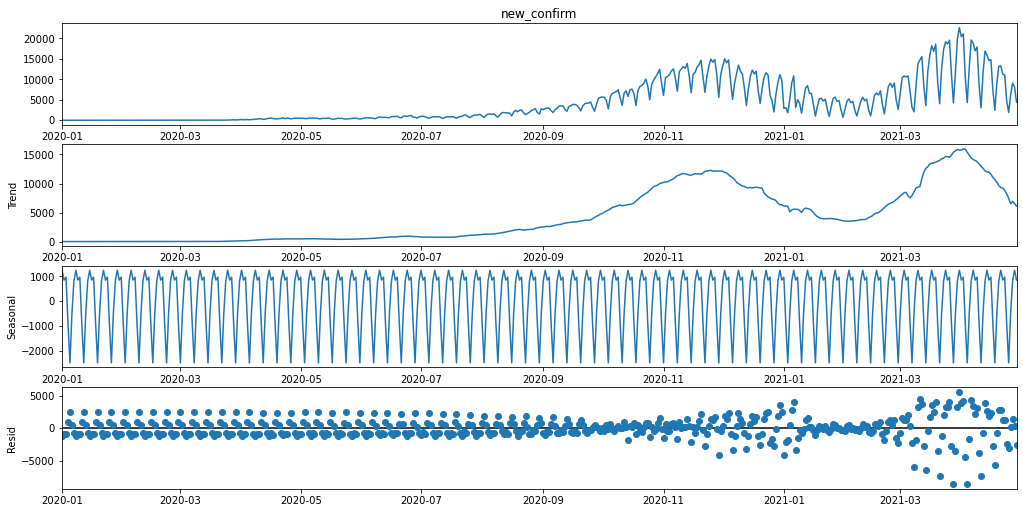

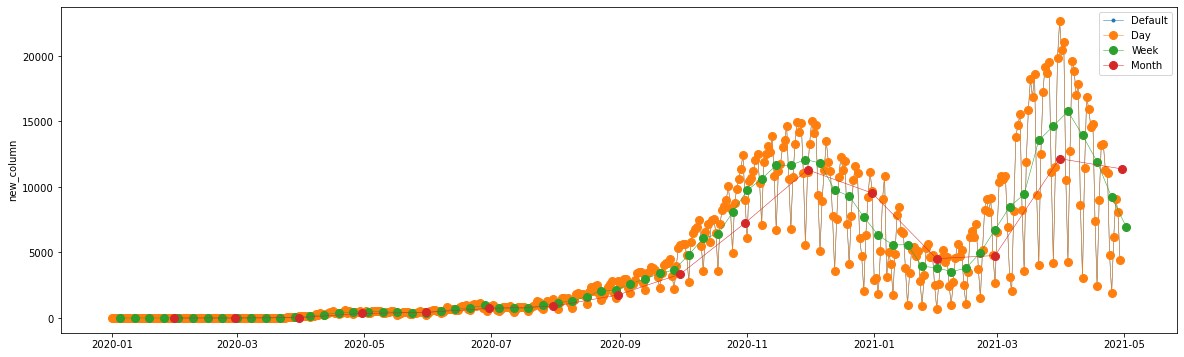

In [15]:
plot_general_info(df, 'new_confirm', 'D')

# prepare data

In [16]:
def create_new_dataframe(df, data_column, cols, fr="D"):
    new_df = pd.DataFrame(df, columns = cols)
    new_df[data_column] = pd.to_datetime(new_df[data_column])
    new_df = new_df.groupby([pd.Grouper(key=time_column,freq=fr), region]).sum().reset_index()

    new_df.index = new_df[data_column]
    del new_df[data_column]
    
    return new_df

In [17]:
new_df = create_new_dataframe(df, time_column, default_features)
new_df.tail()

,registration_area,new_susp,new_confirm,new_death,new_recover
zvit_date,,,,,
2021-04-29,Хмельницька,150,76,3,281
2021-04-29,Черкаська,338,154,0,129
2021-04-29,Чернівецька,120,78,2,69
2021-04-29,Чернігівська,105,114,1,458
2021-04-29,м. Київ,209,396,7,733


In [18]:
new_df.head()

,registration_area,new_susp,new_confirm,new_death,new_recover
zvit_date,,,,,
2020-01-01,Донецька,0,0,1,0
2020-01-07,Донецька,0,0,1,0
2020-01-12,Запорізька,0,0,1,0
2020-01-19,Закарпатська,0,0,1,0
2020-01-22,Донецька,0,0,1,0


In [19]:
# get info of some specific region
new_df = new_df[new_df.registration_area.eq('Львівська')]
new_df

,registration_area,new_susp,new_confirm,new_death,new_recover
zvit_date,,,,,
2020-01-27,Львівська,1,0,0,0
2020-01-29,Львівська,1,0,0,0
2020-03-13,Львівська,1,0,0,0
2020-03-16,Львівська,9,0,0,0
2020-03-17,Львівська,5,0,0,0
...,...,...,...,...,...
2021-04-25,Львівська,295,22,11,154
2021-04-26,Львівська,378,301,16,346
2021-04-27,Львівська,469,645,13,365


In [20]:
new_df[region].unique()

array(['Львівська'], dtype=object)

In [21]:
def update_string_columns(df, column_to_replace):
    unique_values = df[column_to_replace].unique()
    for index, value in enumerate(unique_values):
        df[column_to_replace].replace({value: float(index)}, inplace=True)
    return df, unique_values

In [22]:
filtered_data, region_list = update_string_columns(new_df, region)
filtered_data.head()

,registration_area,new_susp,new_confirm,new_death,new_recover
zvit_date,,,,,
2020-01-27,0.0,1,0,0,0
2020-01-29,0.0,1,0,0,0
2020-03-13,0.0,1,0,0,0
2020-03-16,0.0,9,0,0,0
2020-03-17,0.0,5,0,0,0


In [23]:
del filtered_data[region]

In [24]:
columns = len(filtered_data.columns)
columns

4

In [25]:
scaler = MinMaxScaler(feature_range=(0, columns))
filtered_data = scaler.fit_transform(filtered_data)
filtered_data

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.9580348 , 1.15850921, 1.73333333, 0.79261672],
       [1.36745138, 0.82263134, 1.33333333, 0.65363735],
       [0.93756397, 0.1311181 , 0.4       , 0.49728556]])

In [26]:
from sklearn.model_selection import train_test_split

# # old prepate_data
def split_data(df, test_sz = 0.2):
    return train_test_split(df, test_size=test_sz, shuffle=False)

In [27]:
split_date_number = 0.1
train, test = split_data(filtered_data, split_date_number)

# data split

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

# work with model

In [29]:
n_past = 7
n_features = columns

In [30]:
X_train, y_train = create_dataset(train, n_past)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train
X_test, y_test = create_dataset(test, n_past)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test

In [31]:
def create_model(n_past, n_features, repeats=5, units=4):
    
    model = Sequential()
    for _ in range(repeats):
        model.add(LSTM(units, batch_input_shape=(n_past, n_features, columns), activation='relu', return_sequences=True))
    model.add(LSTM(units, batch_input_shape=(n_past, n_features, columns), activation='relu', return_sequences=False))

    
    model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics=['accuracy'])
    
    return model

In [88]:
model = create_model(n_past, n_features)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (7, 4, 4)                 144       
_________________________________________________________________
lstm_13 (LSTM)               (7, 4, 4)                 144       
_________________________________________________________________
lstm_14 (LSTM)               (7, 4, 4)                 144       
_________________________________________________________________
lstm_15 (LSTM)               (7, 4, 4)                 144       
_________________________________________________________________
lstm_16 (LSTM)               (7, 4, 4)                 144       
_________________________________________________________________
lstm_17 (LSTM)               (7, 4)                    144       
Total params: 864
Trainable params: 864
Non-trainable params: 0
________________________________________________________

# model train

In [33]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True
        

callback=MyThresholdCallback(threshold=0.90)

checkpoint_filepath = './checkpoints/weights.epoch_{epoch:02d}-val_loss_{val_loss:.2f}-val_accuracy_{val_accuracy:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback, callback], verbose=1)

Epoch 1/100
363/363 [==============================] - 22s 11ms/step - loss: 0.4902 - accuracy: 0.3702 - val_loss: 0.7824 - val_accuracy: 0.6765
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2420 - accuracy: 0.6846 - val_loss: 0.7637 - val_accuracy: 0.6765
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2287 - accuracy: 0.7059 - val_loss: 0.7377 - val_accuracy: 0.6765
Epoch 4/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2091 - accuracy: 0.7479 - val_loss: 0.6918 - val_accuracy: 0.6765
Epoch 5/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2050 - accuracy: 0.7379 - val_loss: 0.6904 - val_accuracy: 0.6765
Epoch 6/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2227 - accuracy: 0.7399 - val_loss: 0.7637 - val_accuracy: 0.6765
Epoch 7/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2269 - accuracy: 0.7593 - val_loss: 0.6641 - val_accuracy: 0.67

363/363 [==============================] - 2s 6ms/step - loss: 0.2094 - accuracy: 0.7552 - val_loss: 0.6562 - val_accuracy: 0.6765
Epoch 52/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2074 - accuracy: 0.7407 - val_loss: 0.6388 - val_accuracy: 0.6765
Epoch 53/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2095 - accuracy: 0.7386 - val_loss: 0.6475 - val_accuracy: 0.6765
Epoch 54/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2033 - accuracy: 0.7655 - val_loss: 0.5598 - val_accuracy: 0.6765
Epoch 55/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2004 - accuracy: 0.7957 - val_loss: 0.5901 - val_accuracy: 0.6765
Epoch 56/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2016 - accuracy: 0.7763 - val_loss: 0.6531 - val_accuracy: 0.6765
Epoch 57/100
363/363 [==============================] - 2s 6ms/step - loss: 0.2155 - accuracy: 0.7377 - val_loss: 0.5988 - val_accuracy: 0.6471
Epoch

# choose model from saved

In [89]:
# choose model to use weights or skip to use last
def choose_saved_model(model, model_name = ""):
    try:
        full_model = './checkpoints/{}'.format(model_name)
        model.load_weights(full_model)
    except:
        print("Can't load data")
    
    return model

In [90]:
model = choose_saved_model(model, model_name = "weights.epoch_54-val_loss_0.56-val_accuracy_0.68.h5") # change name at your

In [92]:
def plot_history(history, start = 0, end = -1):
    if end == -1:
        end = len(history.history['loss'])
    
    plt.plot(history.history['loss'][start:end], label = "Train loss")
    plt.plot(history.history['val_loss'][start:end], label = "Test Loss")
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

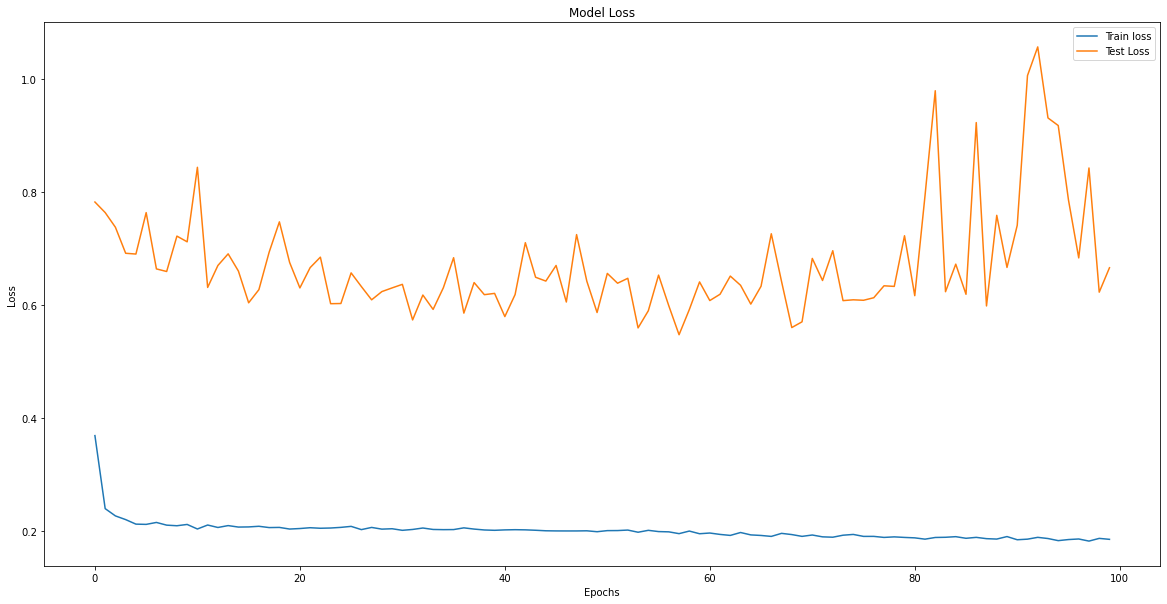

In [93]:
plot_history(history)

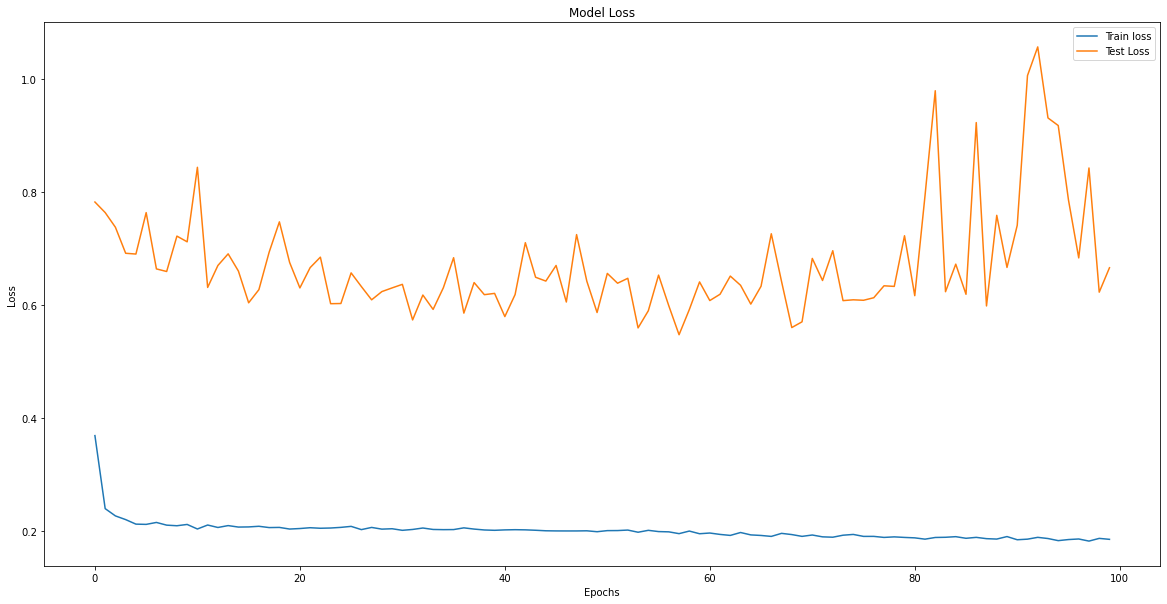

In [94]:
plot_history(history, 0, 100)

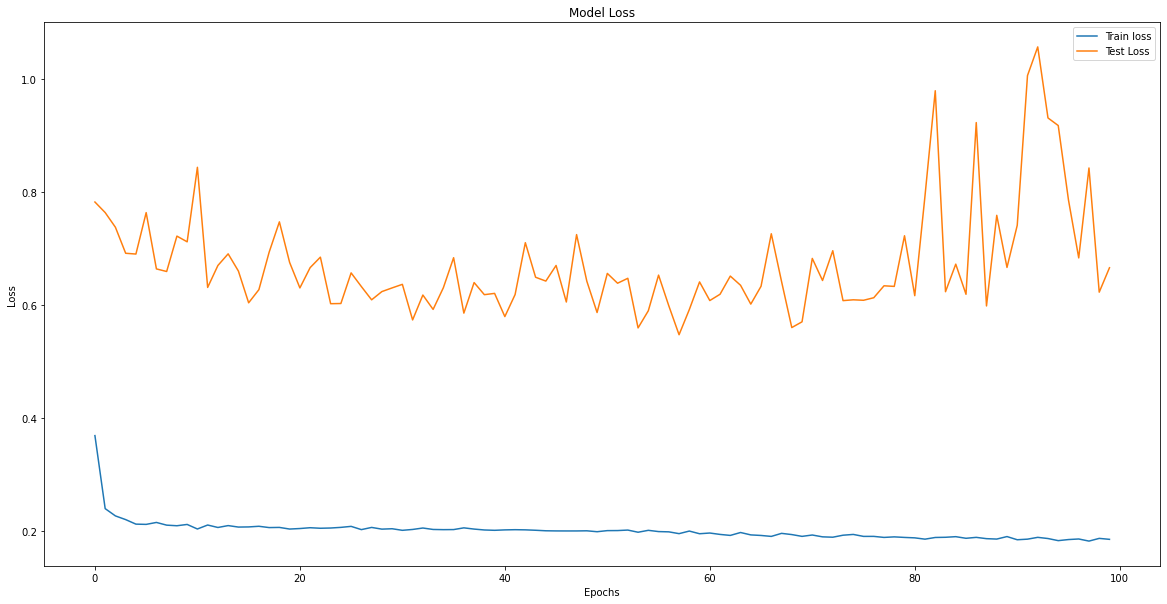

In [95]:
plot_history(history, len(history.history['loss']) - 100, len(history.history['loss']))

In [96]:
def plt_result(model, X, Y, columns = list(new_df.columns)):
    testPredict = model.predict(X, batch_size=n_past)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(Y)
    
    for index in range(4):
        print("Error: ", mean_absolute_percentage_error(testPredict[:, index], testY[:, index]))
        
        plt.title("Show prediction for {} column:".format(columns[index]))
        plt.plot(testY[:, index], label="General")
        plt.plot(testPredict[:, index], label="Predicted")
        plt.legend()
        plt.show()

Error:  0.24921851323286623


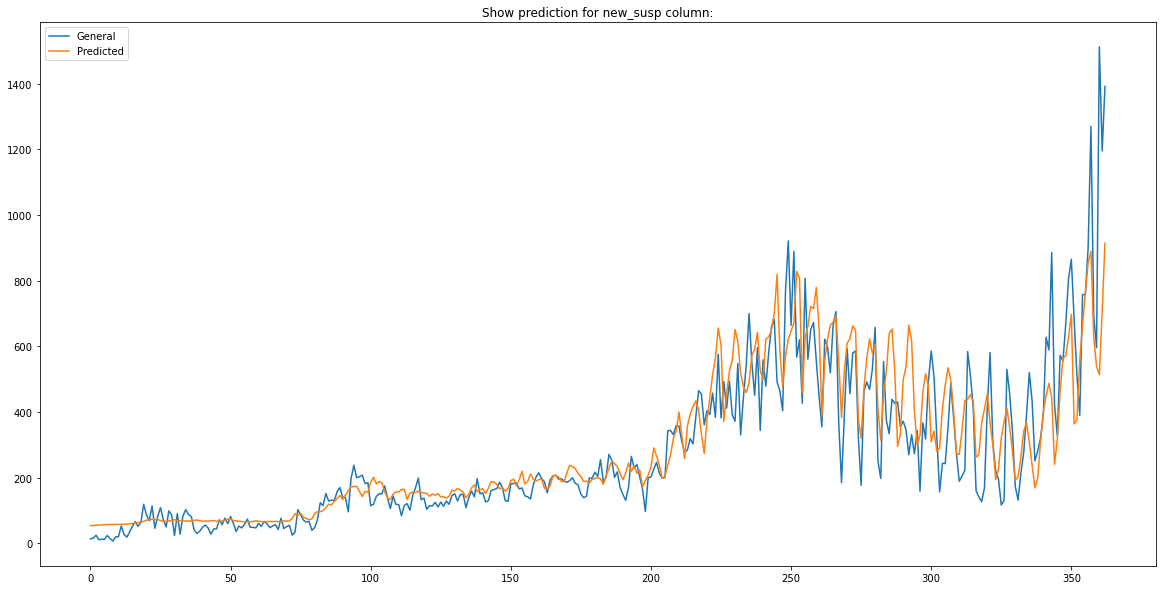

Error:  0.40028349654952744


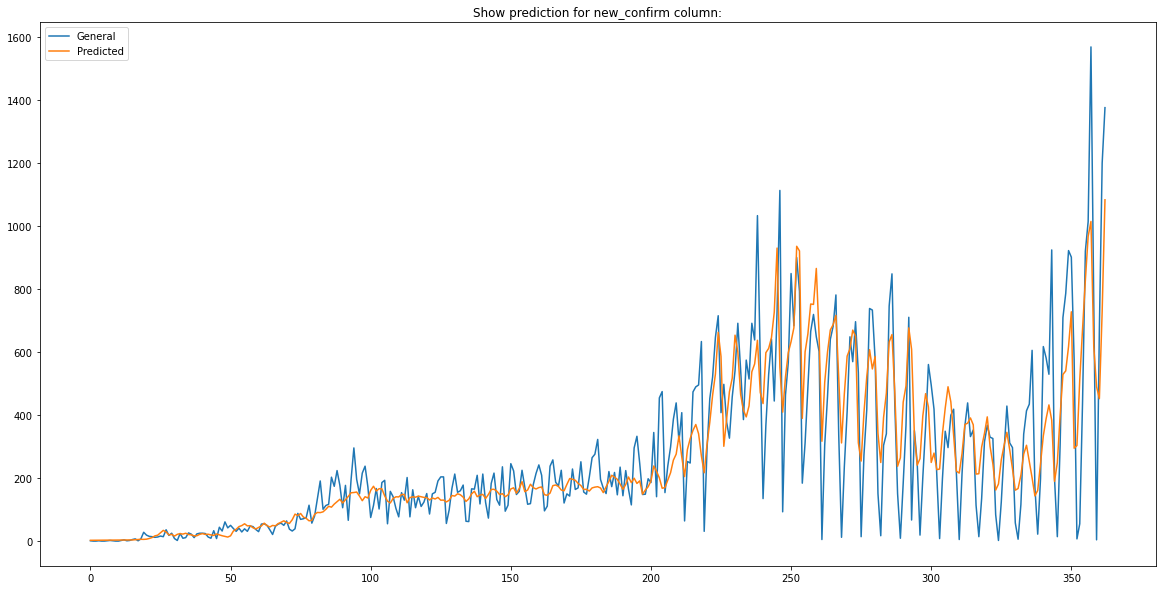

Error:  0.6892010607071312


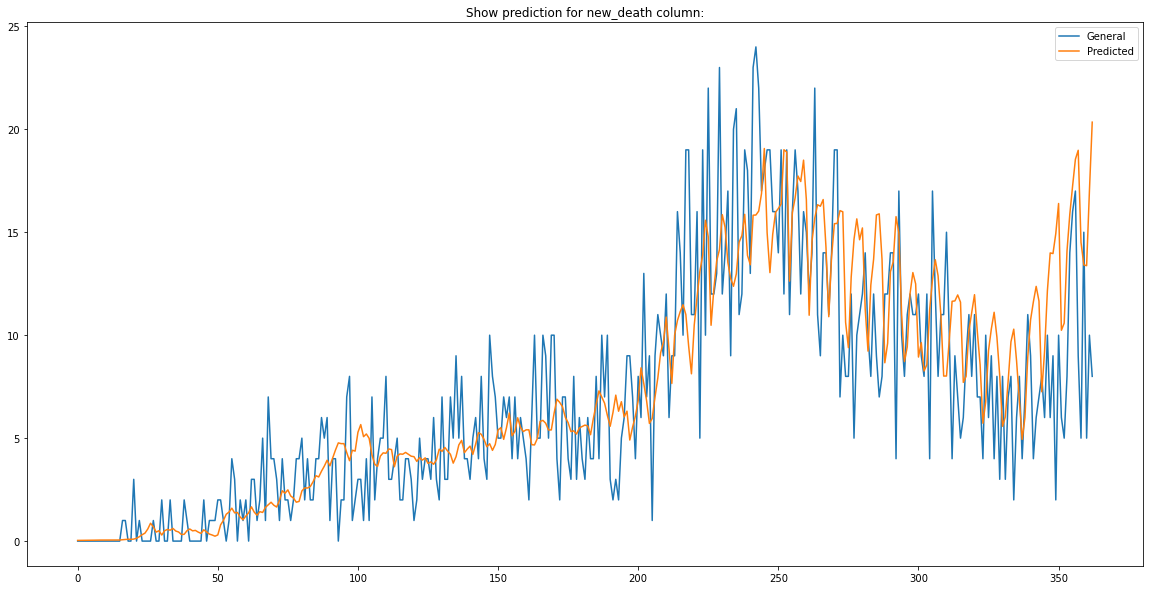

Error:  0.44934633684782255


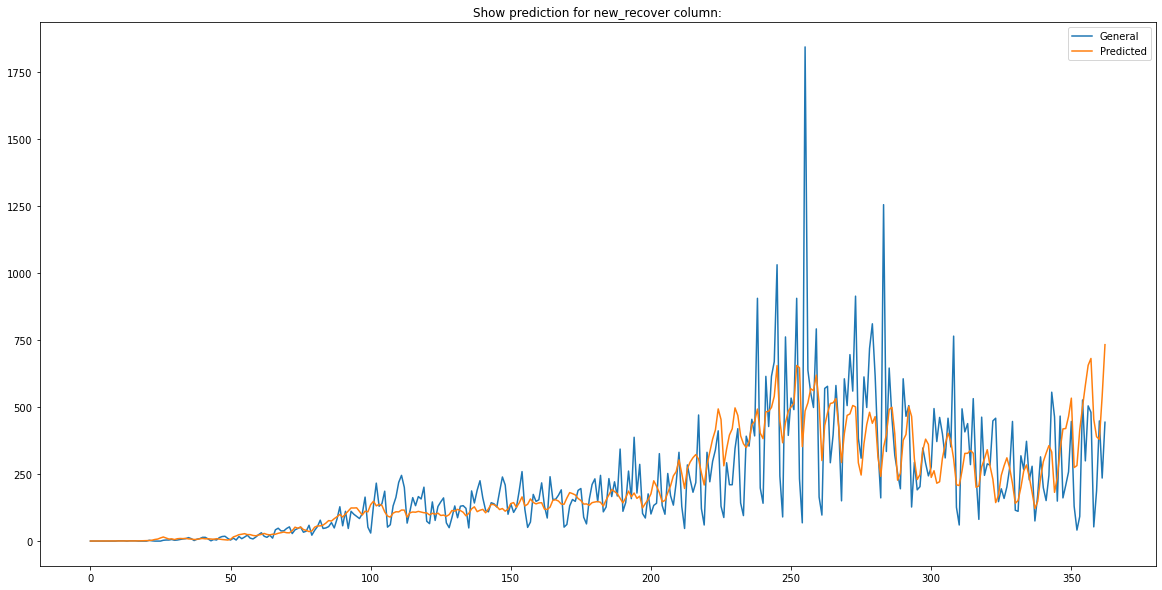

In [97]:
plt_result(model, X_train, y_train)

Error:  0.22399115839840233


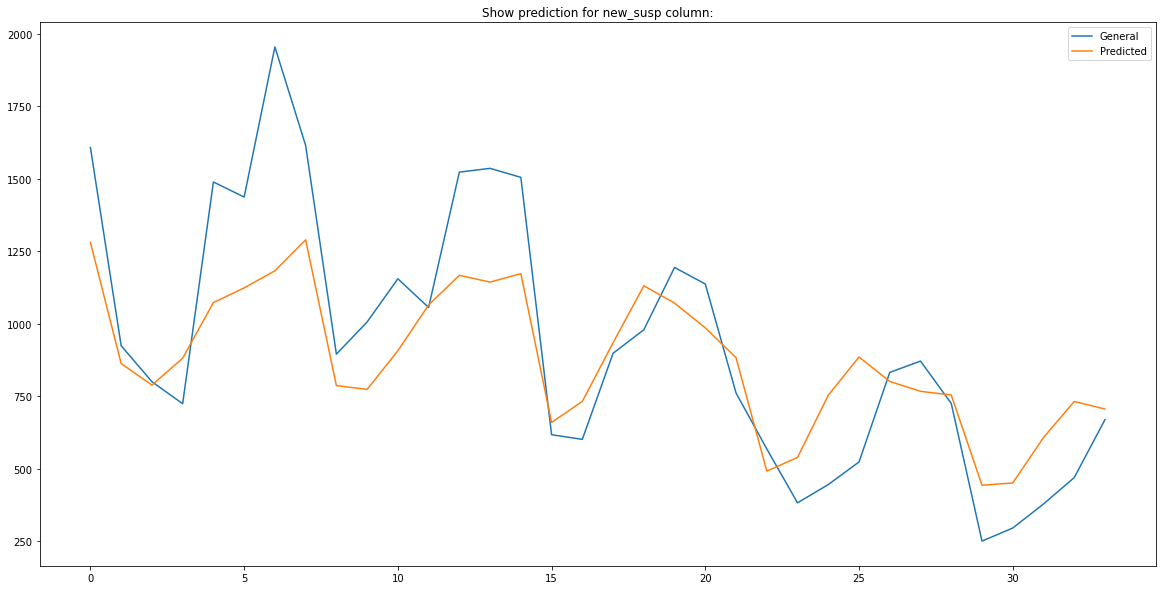

Error:  0.3696494556983962


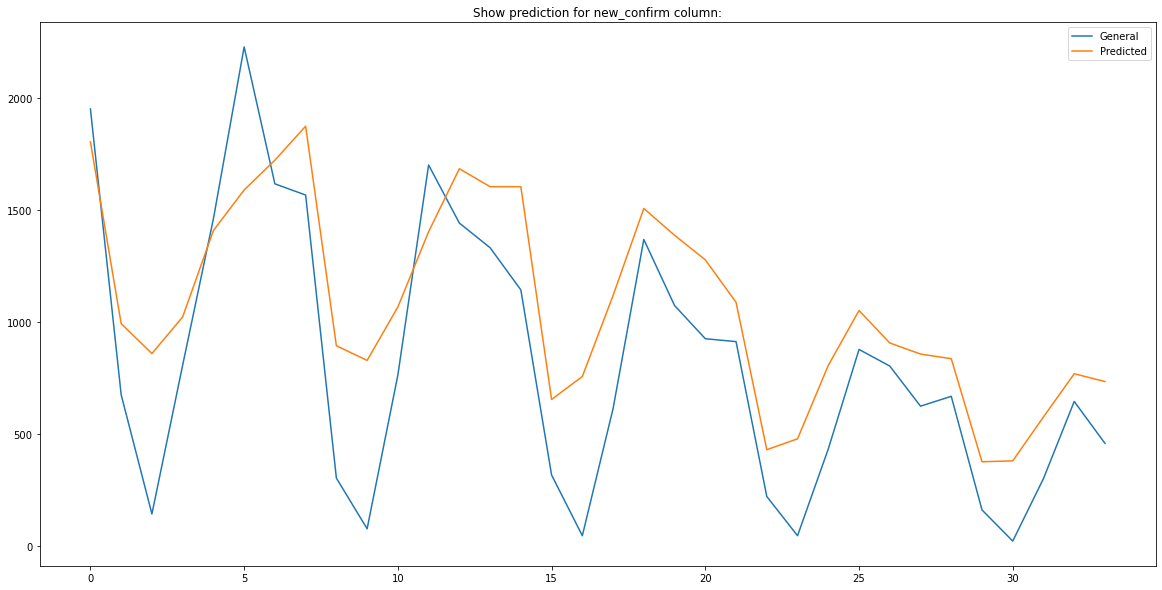

Error:  0.2586277218922044


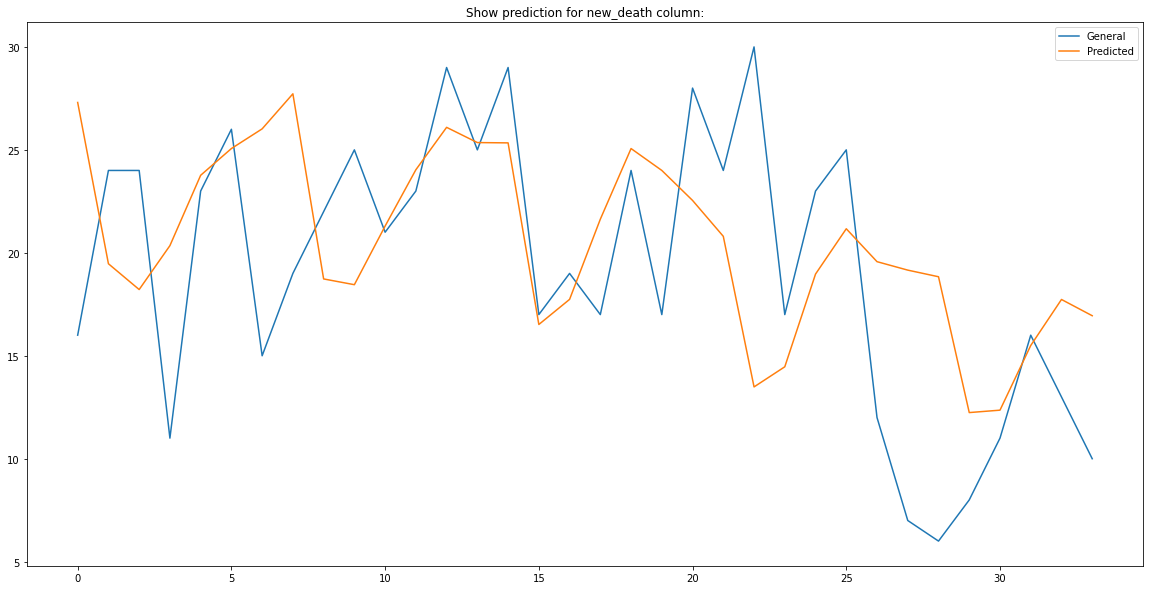

Error:  0.4004156416234459


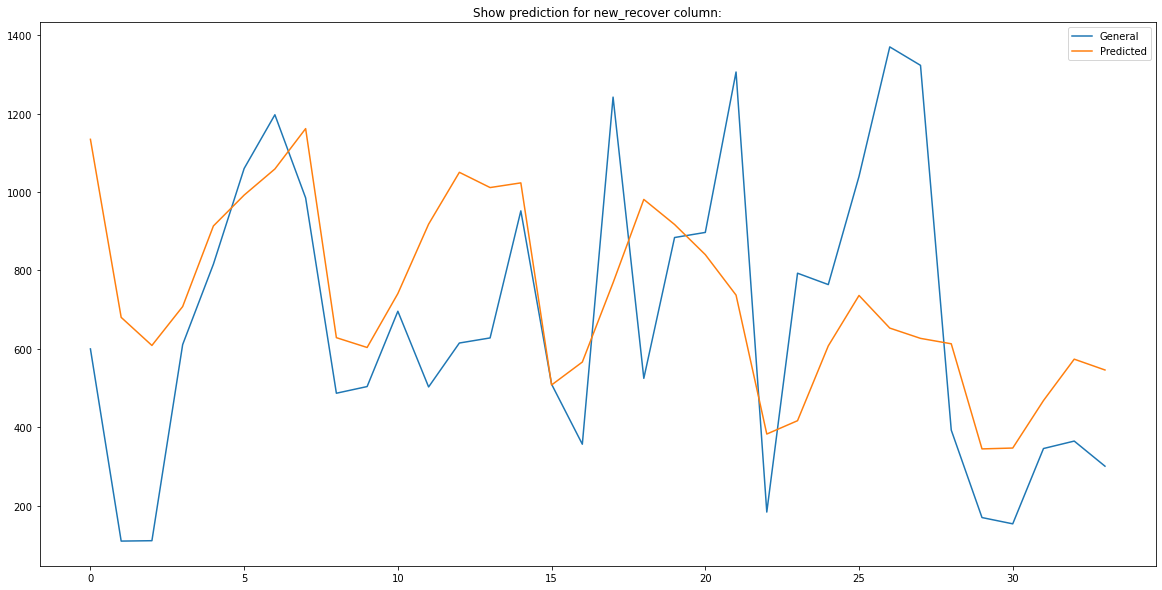

In [98]:
plt_result(model, X_test, y_test)

# model save

In [99]:
import joblib

scaler_filename = "./scaler.save"
joblib.dump(scaler, scaler_filename) 

model.save('./my_model')

INFO:tensorflow:Assets written to: ./my_model/assets


# create map interface

In [100]:
import plotly.express as px

In [101]:
# prepare data to show
def update_df_to_plt(df, registration_area = 'Львівська область', day_col_name='day_number'):
    df[day_col_name] = range(1, 1+len(df))
    df[region] = registration_area
    
    return df

In [102]:
def minMax(x):
    return pd.DataFrame(index=['min','max'],data=[x.min(),x.max()])

In [103]:
def plt_map(df, column):
    fig = px.choropleth(data_frame=df, 
                    geojson=ukraine_regions_geo, 
                    locations=region, # name of dataframe column
                    featureidkey='properties.name',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    range_color=(0, (df[column]['max'] / 2)),
                    color=column,
                    color_continuous_scale="Magma",
                    scope="europe",
                   )
    
    fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [104]:
import requests

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [105]:
repo_url = 'https://raw.githubusercontent.com/EugeneBorshch/ukraine_geojson/master/Ukraine.json'
ukraine_regions_geo = requests.get(repo_url).json()

In [106]:
def get_slider(mx):
    return widgets.IntSlider(
                value=1,
                min=1,
                max=mx,
                step=1,
                description='Day number:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='d'
            )

In [107]:
def show_map(df, transform=False, create_prediction=False, col=["new_susp", "new_confirm", "new_death", "new_recover"]):
    if transform:
        if create_prediction:
            df = model.predict(df, batch_size=n_past)
            
        df = scaler.inverse_transform(df)
        df = pd.DataFrame(df, columns = col, index = new_df.index.tolist()[len(new_df) - len(df):])

    show_df = update_df_to_plt(df)
    print("General number of day is: {};\n".format(len(df)))

    def show_map_prediction(column=col, x=1):
        df_show = show_df[show_df["day_number"] == x]
        frames = [minMax(show_df), df_show,]
        df = pd.concat(frames)
        print("Current date is: {};".format(df.index[len(df) - 1]))
        print("\n\nColumn:{};\nScore:{};\n".format(column, df[column][len(df) - 1]))
      
        return plt_map(df, column)

    slider = get_slider(len(df))
    interact(show_map_prediction, x=slider)

In [108]:
show_map(new_df)

General number of day is: 413;



interactive(children=(Dropdown(description='column', options=('new_susp', 'new_confirm', 'new_death', 'new_rec…

In [109]:
show_map(X_train, True, True)

General number of day is: 363;



interactive(children=(Dropdown(description='column', options=('new_susp', 'new_confirm', 'new_death', 'new_rec…

In [110]:
show_map(X_test, True, True)

General number of day is: 34;



interactive(children=(Dropdown(description='column', options=('new_susp', 'new_confirm', 'new_death', 'new_rec…